## Based on: http://www.bmva.org/bmvc/2015/papers/paper109/paper109.pdf

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
plt.rcParams['figure.figsize'] = [50, 10]
from PIL import Image
from PIL import ImageOps
from PIL import Image, ImageDraw
from sklearn.utils import shuffle
import tensorflow as tf
import seaborn as sn
import numpy as np
import pandas as pd
from flow_from_dataframe import flow_from_dataframe
from sklearn.model_selection import train_test_split
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
%matplotlib inline

Using TensorFlow backend.


In [16]:
KITTI_IMAGE_WIDTH = 1242
STIXEL_WIDTH = 24
IMAGE_SIZE = (225,STIXEL_WIDTH)
maximum_offset = KITTI_IMAGE_WIDTH//STIXEL_WIDTH 
BATCH_SIZE = 5000
NUMBER_OF_BINS = 50

In [3]:
df = pd.read_csv('data_train/cropped_set/cropped.csv')
# bin labels
bins = np.linspace(0, 225, NUMBER_OF_BINS)
binned_values = []
for index, row in df.iterrows():
    binned_values.append(np.argmax(np.histogram(row['y'],bins)[0]))
df['binned_y'] = pd.Series(binned_values)
df.head()

,img_path,y,binned_y
0,data_train/cropped_set/stixels_cropped/0.png,92,20
1,data_train/cropped_set/stixels_cropped/1.png,87,18
2,data_train/cropped_set/stixels_cropped/2.png,86,18
3,data_train/cropped_set/stixels_cropped/3.png,79,17
4,data_train/cropped_set/stixels_cropped/4.png,79,17


In [5]:
columns = ['img_path', 'y']
df_cropped = pd.DataFrame(columns=columns)

CROPPED_PATH = 'data_train/cropped_set/stixels_cropped/'

for i in range(len(df['y'])):
    if df['y'][i] < 150:
        continue
    stixel = Image.open(df['img_path'][i])
    stixel_height = stixel.size[1]
    y = df['y'][i]-150
    path = CROPPED_PATH+str(i)+".png"
    out = ImageOps.crop(stixel, (0,150,0,0))
    out.save(path, "png")
    df_cropped = df_cropped.append({'img_path':path,'y':y},ignore_index=True)
    print(i/len(df['y']))
    clear_output(wait=True)

0.999991542052913


In [7]:
df_cropped.to_csv('cropped.csv',index=False)

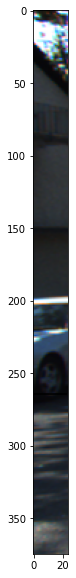

(24, 225)


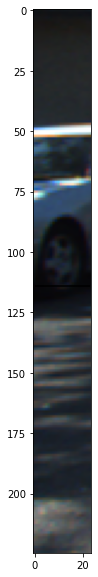

(24, 225)


In [105]:
i=250

stixel = Image.open(df['img_path'][i])
stixel_height = stixel.size[1]
plt.imshow(stixel)
plt.hlines(y=df['y'][i],xmin=0,xmax=23)
plt.show()
y = df['y'][i]-150
path = CROPPED_PATH+str(i)+".png"
out = ImageOps.crop(stixel, (0,150,0,0))
print(out.size)
plt.imshow(out)
plt.hlines(y=y,xmin=0,xmax=23)
plt.show()
print(out.size)

In [61]:
df_cropped.to_csv('cropped.csv',index=False)

In [56]:
relatives = []
for val in list(values_distribution):
    if(val == 0):
        relatives.append(0)
    else:
        relatives.append(val/sum(values_distribution))


NameError: name 'values_distribution' is not defined

In [435]:
sum(relatives[150:350])

0.995060558901143

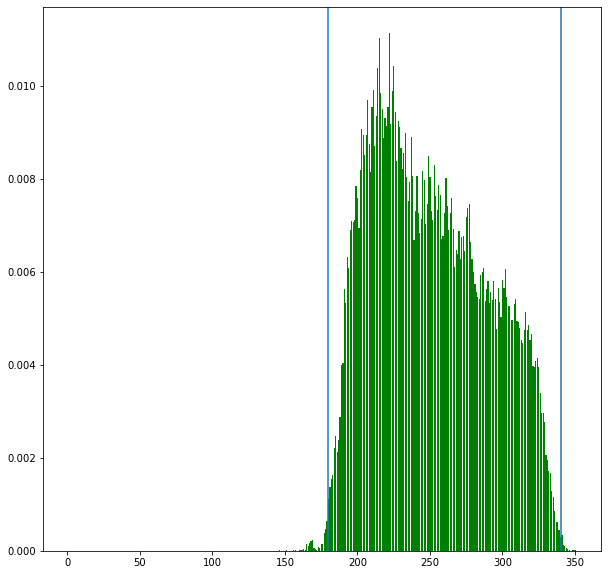

In [434]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.bar(np.linspace(1,max(df['y'])+1,max(df['y'])+1), relatives, color='green')
plt.axvline(x=180, ymin=0, ymax=1)
plt.axvline(x=340, ymin=0, ymax=1)

In [4]:
test_df, train_df = np.split(df, [int(len(df)*0.2)], axis=0)

core_idg = ImageDataGenerator(
    horizontal_flip = True,
    rescale=1.0/255.0)

train_generator = flow_from_dataframe(
    core_idg,train_df,
    'img_path',
    'binned_y',
    'data_train/cropped_set',
    NUMBER_OF_BINS,
    target_size = IMAGE_SIZE, 
    batch_size = BATCH_SIZE)
test_generator = flow_from_dataframe(
    core_idg,test_df,
    'img_path',
    'binned_y',
    'data_train/cropped_set',
    NUMBER_OF_BINS,
    target_size = IMAGE_SIZE, 
    batch_size = BATCH_SIZE)
#print('%d overlapping images.'%list(set(list(test_generator._filepaths)).intersection(list(train_generator._filepaths))))

Found 118231 images belonging to 1 classes.
Found 118231 images belonging to 1 classes.


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


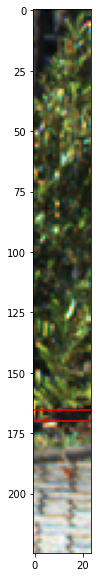

In [9]:
plt.rcParams['figure.figsize'] = [20, 10]

i=0
for t in train_generator:
    plt.imshow(t[0][0])
    print(t[1][0])
    for j in range(len(t[1][0])):
        if t[1][0][j] == 1:
            plt.axhline(y=bins[j],color='red')
            plt.axhline(y=bins[j+1],color='red')
    plt.show()
    break

In [6]:
import tensorflow as tf
import keras.backend as K


# Ground truth needs to be in that form: [ACTUAL_VALUE,BIN_OF_ACTUAL_VALUE, (NUMBER_OF_BINS-2)*Zero (zero padding)]
# This is due to keras demanding dim(y_true) == dim(y_pred) But in this case this is not wanted.
# Current notebook DOES NOT generate y_true in that manner, since this loss function is not working (for now).

def P(y,y_pred,i):
    i_1 = i+1
    a_i = K.cast(K.gather(y_pred,i),'float32')
    a_i_1 = K.cast(K.gather(y_pred,i_1),'float32')
    c_i = K.cast(K.gather(bins,i),'float32')
    c_i_1 = K.cast(K.gather(bins,i_1),'float32')
    denominator = c_i_1 - c_i
    first_half = a_i * (((c_i_1 - y) / denominator))
    second_half = a_i_1 * ((y - c_i) / denominator)
    return  first_half + second_half

def pl_loss(y_true,y_pred):
    y_true = K.cast(K.gather(y_true,0),'float32')
    y_pred = K.cast(K.flatten(y_pred),"float32")
    i = K.cast(K.gather(K.flatten(y_true),1),'int32')
    return P(y_true,y_pred,i)

In [11]:
from keras.layers import Input,Conv2D,MaxPooling2D,Dense,Dropout,Flatten
from keras import Model
from keras.optimizers import Adam

def StixelNet(loss='mean_squared_error',metrics=['accuracy'],number_of_bins=50):
    inputs = Input((IMAGE_SIZE[0],IMAGE_SIZE[1],3))
    conv1 = Conv2D(64, (5,11), activation='relu',padding='same', kernel_initializer='he_normal')(inputs)
    pool1 = MaxPooling2D(pool_size=(4, 8))(conv1)
    conv2 = Conv2D(200, (3,5), activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    pool2 = MaxPooling2D(pool_size=(4, 3))(conv2)
    flattened = Flatten()(pool2)
    dense1 = Dense(1024, kernel_initializer='he_normal', activation='relu')(flattened)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(2048, kernel_initializer='he_normal', activation='relu')(dropout1)
    dropout2 = Dropout(0.5)(dense2)
    dense3 = Dense(number_of_bins, kernel_initializer='he_normal', activation='softmax')(dropout2)
    model = Model(inputs=inputs, outputs=dense3)
    model.compile(optimizer=Adam(lr=0.001), loss=loss, metrics=metrics)
    return model

In [12]:
model = StixelNet(number_of_bins=NUMBER_OF_BINS,metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy()])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 225, 24, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 225, 24, 64)       10624     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 3, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 3, 200)        192200    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 1, 200)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2800)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2868

In [17]:
steps_per_epoch = train_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE

model.load_weights('best_model.hdf5')

checkpoint = ModelCheckpoint(
    "best_model.hdf5", 
    monitor='val_loss',
    verbose=1,
    save_best_only=True, 
    mode='min', 
    period=1, 
    save_weights_only=True)

history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=400,
                              validation_data=test_generator,
                              validation_steps=test_steps,
                              callbacks=[checkpoint])

Epoch 1/400
18/18 [==============================] - 8s 432ms/step - loss: 0.0137 - accuracy: 0.4402 - top_k_categorical_accuracy: 0.8541 - val_loss: 0.0148 - val_accuracy: 0.3970 - val_top_k_categorical_accuracy: 0.8551

Epoch 00001: val_loss improved from inf to 0.01478, saving model to best_model.hdf5
Epoch 2/400
18/18 [==============================] - 7s 389ms/step - loss: 0.0138 - accuracy: 0.4420 - top_k_categorical_accuracy: 0.8552 - val_loss: 0.0144 - val_accuracy: 0.4045 - val_top_k_categorical_accuracy: 0.8559

Epoch 00002: val_loss improved from 0.01478 to 0.01442, saving model to best_model.hdf5
Epoch 3/400
18/18 [==============================] - 7s 404ms/step - loss: 0.0138 - accuracy: 0.4373 - top_k_categorical_accuracy: 0.8558 - val_loss: 0.0149 - val_accuracy: 0.3845 - val_top_k_categorical_accuracy: 0.8557

Epoch 00003: val_loss did not improve from 0.01442
Epoch 4/400
18/18 [==============================] - 7s 408ms/step - loss: 0.0140 - accuracy: 0.4348 - top_k_ca


Epoch 00030: val_loss did not improve from 0.01422
Epoch 31/400
18/18 [==============================] - 7s 376ms/step - loss: 0.0140 - accuracy: 0.4312 - top_k_categorical_accuracy: 0.8565 - val_loss: 0.0148 - val_accuracy: 0.3850 - val_top_k_categorical_accuracy: 0.8566

Epoch 00031: val_loss did not improve from 0.01422
Epoch 32/400
18/18 [==============================] - 7s 399ms/step - loss: 0.0137 - accuracy: 0.4436 - top_k_categorical_accuracy: 0.8566 - val_loss: 0.0149 - val_accuracy: 0.3875 - val_top_k_categorical_accuracy: 0.8566

Epoch 00032: val_loss did not improve from 0.01422
Epoch 33/400
18/18 [==============================] - 7s 389ms/step - loss: 0.0134 - accuracy: 0.4709 - top_k_categorical_accuracy: 0.8567 - val_loss: 0.0150 - val_accuracy: 0.3755 - val_top_k_categorical_accuracy: 0.8567

Epoch 00033: val_loss did not improve from 0.01422
Epoch 34/400
18/18 [==============================] - 7s 378ms/step - loss: 0.0136 - accuracy: 0.4556 - top_k_categorical_accu


Epoch 00060: val_loss did not improve from 0.01404
Epoch 61/400
18/18 [==============================] - 7s 402ms/step - loss: 0.0133 - accuracy: 0.4643 - top_k_categorical_accuracy: 0.8583 - val_loss: 0.0156 - val_accuracy: 0.3950 - val_top_k_categorical_accuracy: 0.8583

Epoch 00061: val_loss did not improve from 0.01404
Epoch 62/400
18/18 [==============================] - 7s 388ms/step - loss: 0.0134 - accuracy: 0.4547 - top_k_categorical_accuracy: 0.8583 - val_loss: 0.0155 - val_accuracy: 0.4025 - val_top_k_categorical_accuracy: 0.8583

Epoch 00062: val_loss did not improve from 0.01404
Epoch 63/400
18/18 [==============================] - 7s 388ms/step - loss: 0.0133 - accuracy: 0.4604 - top_k_categorical_accuracy: 0.8584 - val_loss: 0.0153 - val_accuracy: 0.3750 - val_top_k_categorical_accuracy: 0.8584

Epoch 00063: val_loss did not improve from 0.01404
Epoch 64/400
18/18 [==============================] - 7s 376ms/step - loss: 0.0132 - accuracy: 0.4672 - top_k_categorical_accu


Epoch 00090: val_loss did not improve from 0.01404
Epoch 91/400
18/18 [==============================] - 7s 392ms/step - loss: 0.0128 - accuracy: 0.4937 - top_k_categorical_accuracy: 0.8600 - val_loss: 0.0158 - val_accuracy: 0.3755 - val_top_k_categorical_accuracy: 0.8600

Epoch 00091: val_loss did not improve from 0.01404
Epoch 92/400
18/18 [==============================] - 7s 391ms/step - loss: 0.0128 - accuracy: 0.4870 - top_k_categorical_accuracy: 0.8600 - val_loss: 0.0149 - val_accuracy: 0.3870 - val_top_k_categorical_accuracy: 0.8601

Epoch 00092: val_loss did not improve from 0.01404
Epoch 93/400
18/18 [==============================] - 7s 397ms/step - loss: 0.0129 - accuracy: 0.4857 - top_k_categorical_accuracy: 0.8601 - val_loss: 0.0144 - val_accuracy: 0.3845 - val_top_k_categorical_accuracy: 0.8601

Epoch 00093: val_loss did not improve from 0.01404
Epoch 94/400
18/18 [==============================] - 7s 396ms/step - loss: 0.0130 - accuracy: 0.4842 - top_k_categorical_accu


Epoch 00120: val_loss did not improve from 0.01404
Epoch 121/400
18/18 [==============================] - 7s 385ms/step - loss: 0.0122 - accuracy: 0.5188 - top_k_categorical_accuracy: 0.8618 - val_loss: 0.0152 - val_accuracy: 0.3740 - val_top_k_categorical_accuracy: 0.8618

Epoch 00121: val_loss did not improve from 0.01404
Epoch 122/400
18/18 [==============================] - 7s 395ms/step - loss: 0.0125 - accuracy: 0.5101 - top_k_categorical_accuracy: 0.8618 - val_loss: 0.0162 - val_accuracy: 0.3715 - val_top_k_categorical_accuracy: 0.8618

Epoch 00122: val_loss did not improve from 0.01404
Epoch 123/400
18/18 [==============================] - 7s 393ms/step - loss: 0.0122 - accuracy: 0.5218 - top_k_categorical_accuracy: 0.8619 - val_loss: 0.0154 - val_accuracy: 0.3840 - val_top_k_categorical_accuracy: 0.8619

Epoch 00123: val_loss did not improve from 0.01404
Epoch 124/400
18/18 [==============================] - 7s 393ms/step - loss: 0.0124 - accuracy: 0.5117 - top_k_categorical_


Epoch 00150: val_loss did not improve from 0.01404
Epoch 151/400
18/18 [==============================] - 7s 395ms/step - loss: 0.0117 - accuracy: 0.5528 - top_k_categorical_accuracy: 0.8635 - val_loss: 0.0160 - val_accuracy: 0.3940 - val_top_k_categorical_accuracy: 0.8635

Epoch 00151: val_loss did not improve from 0.01404
Epoch 152/400
18/18 [==============================] - 7s 394ms/step - loss: 0.0119 - accuracy: 0.5467 - top_k_categorical_accuracy: 0.8636 - val_loss: 0.0163 - val_accuracy: 0.3710 - val_top_k_categorical_accuracy: 0.8636

Epoch 00152: val_loss did not improve from 0.01404
Epoch 153/400
18/18 [==============================] - 7s 395ms/step - loss: 0.0120 - accuracy: 0.5370 - top_k_categorical_accuracy: 0.8636 - val_loss: 0.0153 - val_accuracy: 0.3860 - val_top_k_categorical_accuracy: 0.8636

Epoch 00153: val_loss did not improve from 0.01404
Epoch 154/400
18/18 [==============================] - 7s 392ms/step - loss: 0.0121 - accuracy: 0.5336 - top_k_categorical_


Epoch 00180: val_loss did not improve from 0.01404
Epoch 181/400
18/18 [==============================] - 7s 406ms/step - loss: 0.0114 - accuracy: 0.5593 - top_k_categorical_accuracy: 0.8651 - val_loss: 0.0156 - val_accuracy: 0.3800 - val_top_k_categorical_accuracy: 0.8651

Epoch 00181: val_loss did not improve from 0.01404
Epoch 182/400
18/18 [==============================] - 7s 414ms/step - loss: 0.0112 - accuracy: 0.5667 - top_k_categorical_accuracy: 0.8651 - val_loss: 0.0155 - val_accuracy: 0.3810 - val_top_k_categorical_accuracy: 0.8651

Epoch 00182: val_loss did not improve from 0.01404
Epoch 183/400
18/18 [==============================] - 7s 409ms/step - loss: 0.0113 - accuracy: 0.5646 - top_k_categorical_accuracy: 0.8652 - val_loss: 0.0157 - val_accuracy: 0.3795 - val_top_k_categorical_accuracy: 0.8652

Epoch 00183: val_loss did not improve from 0.01404
Epoch 184/400
18/18 [==============================] - 8s 437ms/step - loss: 0.0113 - accuracy: 0.5620 - top_k_categorical_


Epoch 00210: val_loss did not improve from 0.01404
Epoch 211/400
18/18 [==============================] - 7s 411ms/step - loss: 0.0114 - accuracy: 0.5567 - top_k_categorical_accuracy: 0.8667 - val_loss: 0.0170 - val_accuracy: 0.3895 - val_top_k_categorical_accuracy: 0.8667

Epoch 00211: val_loss did not improve from 0.01404
Epoch 212/400
18/18 [==============================] - 7s 407ms/step - loss: 0.0108 - accuracy: 0.5911 - top_k_categorical_accuracy: 0.8668 - val_loss: 0.0162 - val_accuracy: 0.3760 - val_top_k_categorical_accuracy: 0.8668

Epoch 00212: val_loss did not improve from 0.01404
Epoch 213/400
18/18 [==============================] - 7s 408ms/step - loss: 0.0108 - accuracy: 0.5861 - top_k_categorical_accuracy: 0.8668 - val_loss: 0.0167 - val_accuracy: 0.3720 - val_top_k_categorical_accuracy: 0.8669

Epoch 00213: val_loss did not improve from 0.01404
Epoch 214/400
18/18 [==============================] - 7s 407ms/step - loss: 0.0109 - accuracy: 0.5810 - top_k_categorical_


Epoch 00240: val_loss did not improve from 0.01404
Epoch 241/400
18/18 [==============================] - 8s 421ms/step - loss: 0.0110 - accuracy: 0.5818 - top_k_categorical_accuracy: 0.8682 - val_loss: 0.0161 - val_accuracy: 0.3765 - val_top_k_categorical_accuracy: 0.8683

Epoch 00241: val_loss did not improve from 0.01404
Epoch 242/400
18/18 [==============================] - 7s 411ms/step - loss: 0.0110 - accuracy: 0.5760 - top_k_categorical_accuracy: 0.8683 - val_loss: 0.0158 - val_accuracy: 0.3670 - val_top_k_categorical_accuracy: 0.8683

Epoch 00242: val_loss did not improve from 0.01404
Epoch 243/400
18/18 [==============================] - 7s 410ms/step - loss: 0.0110 - accuracy: 0.5840 - top_k_categorical_accuracy: 0.8683 - val_loss: 0.0166 - val_accuracy: 0.3705 - val_top_k_categorical_accuracy: 0.8684

Epoch 00243: val_loss did not improve from 0.01404
Epoch 244/400
18/18 [==============================] - 7s 410ms/step - loss: 0.0102 - accuracy: 0.6150 - top_k_categorical_


Epoch 00270: val_loss did not improve from 0.01404
Epoch 271/400
18/18 [==============================] - 7s 409ms/step - loss: 0.0105 - accuracy: 0.5992 - top_k_categorical_accuracy: 0.8698 - val_loss: 0.0149 - val_accuracy: 0.3960 - val_top_k_categorical_accuracy: 0.8698

Epoch 00271: val_loss did not improve from 0.01404
Epoch 272/400
18/18 [==============================] - 7s 414ms/step - loss: 0.0107 - accuracy: 0.5963 - top_k_categorical_accuracy: 0.8698 - val_loss: 0.0163 - val_accuracy: 0.3695 - val_top_k_categorical_accuracy: 0.8698

Epoch 00272: val_loss did not improve from 0.01404
Epoch 273/400
18/18 [==============================] - 7s 410ms/step - loss: 0.0109 - accuracy: 0.5882 - top_k_categorical_accuracy: 0.8699 - val_loss: 0.0158 - val_accuracy: 0.3770 - val_top_k_categorical_accuracy: 0.8699

Epoch 00273: val_loss did not improve from 0.01404
Epoch 274/400
18/18 [==============================] - 7s 408ms/step - loss: 0.0106 - accuracy: 0.5997 - top_k_categorical_


Epoch 00300: val_loss did not improve from 0.01404
Epoch 301/400
18/18 [==============================] - 8s 450ms/step - loss: 0.0101 - accuracy: 0.6221 - top_k_categorical_accuracy: 0.8712 - val_loss: 0.0170 - val_accuracy: 0.3445 - val_top_k_categorical_accuracy: 0.8712

Epoch 00301: val_loss did not improve from 0.01404
Epoch 302/400
18/18 [==============================] - 8s 439ms/step - loss: 0.0101 - accuracy: 0.6157 - top_k_categorical_accuracy: 0.8712 - val_loss: 0.0168 - val_accuracy: 0.3695 - val_top_k_categorical_accuracy: 0.8712

Epoch 00302: val_loss did not improve from 0.01404
Epoch 303/400
18/18 [==============================] - 7s 409ms/step - loss: 0.0105 - accuracy: 0.6023 - top_k_categorical_accuracy: 0.8713 - val_loss: 0.0165 - val_accuracy: 0.3445 - val_top_k_categorical_accuracy: 0.8713

Epoch 00303: val_loss did not improve from 0.01404
Epoch 304/400
18/18 [==============================] - 7s 413ms/step - loss: 0.0102 - accuracy: 0.6124 - top_k_categorical_

KeyboardInterrupt: 

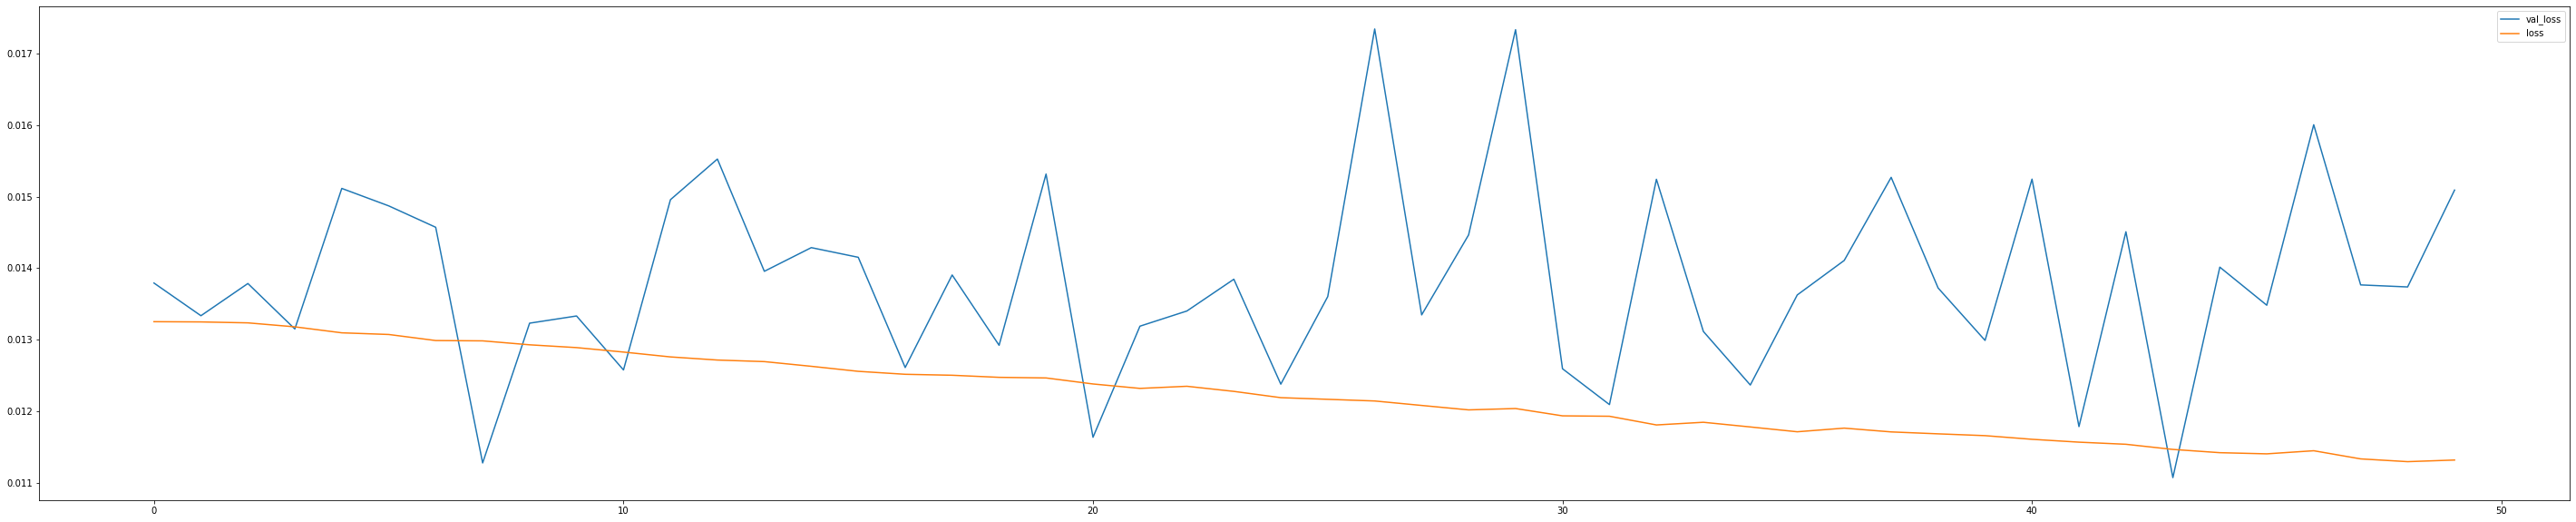

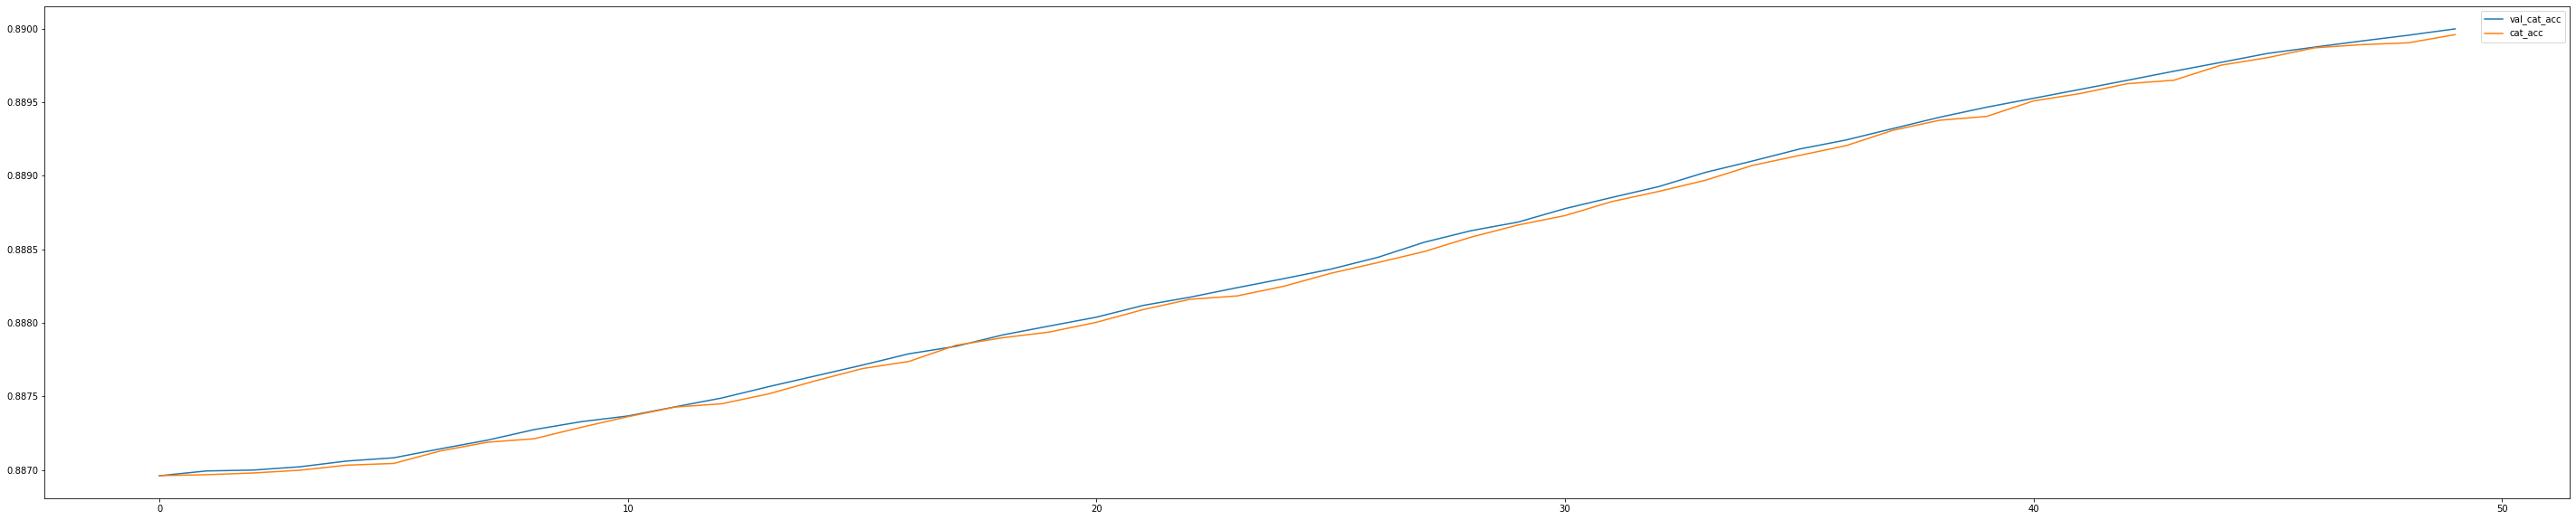

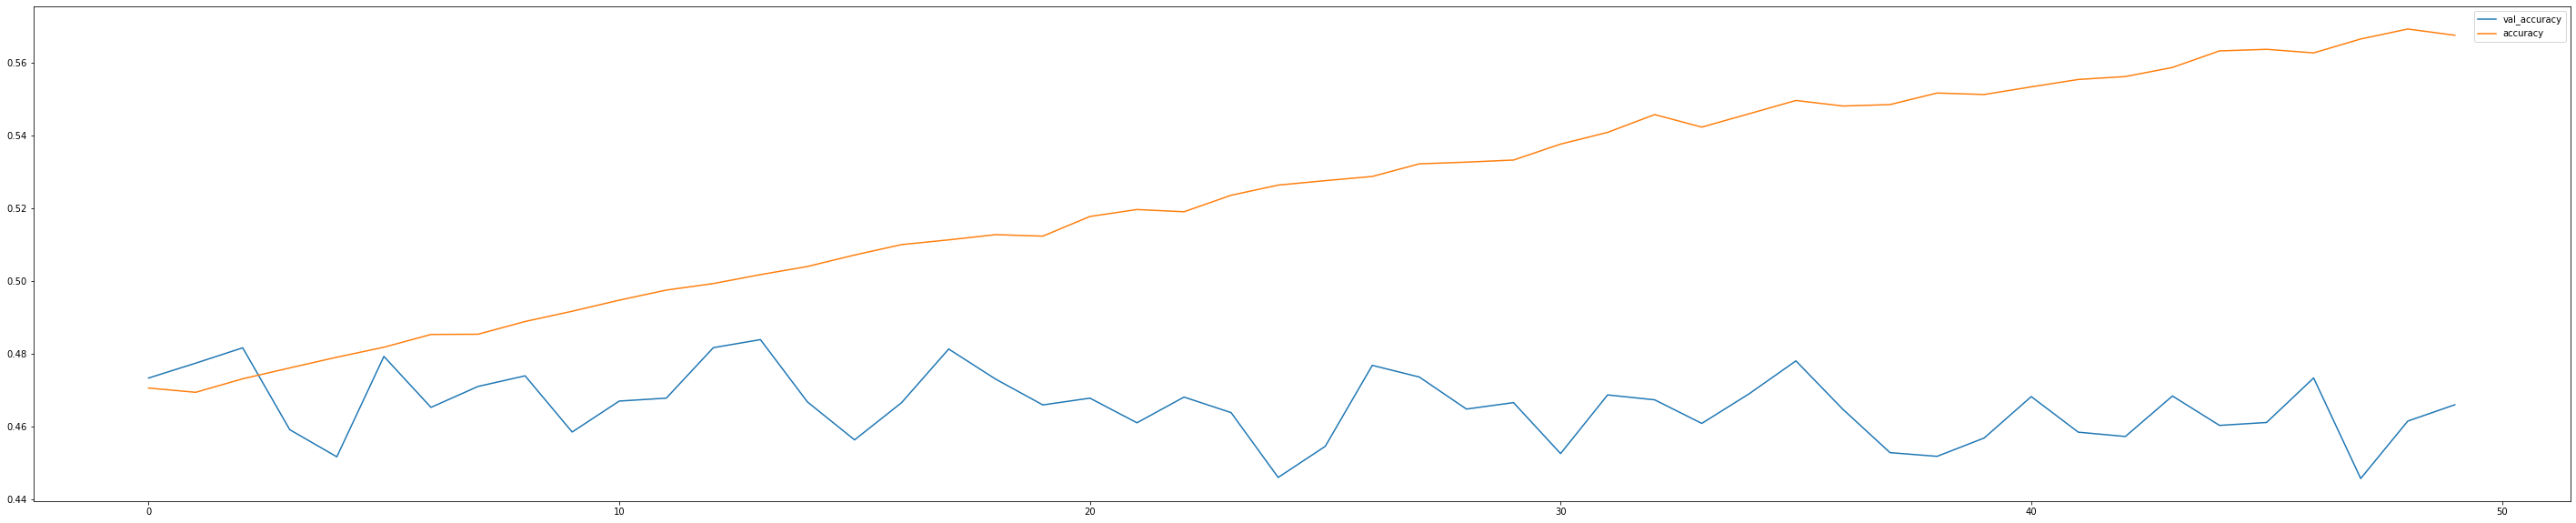

In [250]:
plt.plot(history.history.get('val_loss'),label='val_loss')
plt.plot(history.history.get('loss'),label='loss')
plt.legend()
plt.show()

plt.plot(history.history.get('val_top_k_categorical_accuracy'),label='val_cat_acc')
plt.plot(history.history.get('top_k_categorical_accuracy'),label='cat_acc')
plt.legend()
plt.show()

plt.plot(history.history.get('val_accuracy'),label='val_accuracy')
plt.plot(history.history.get('accuracy'),label='accuracy')
plt.legend()
plt.show()

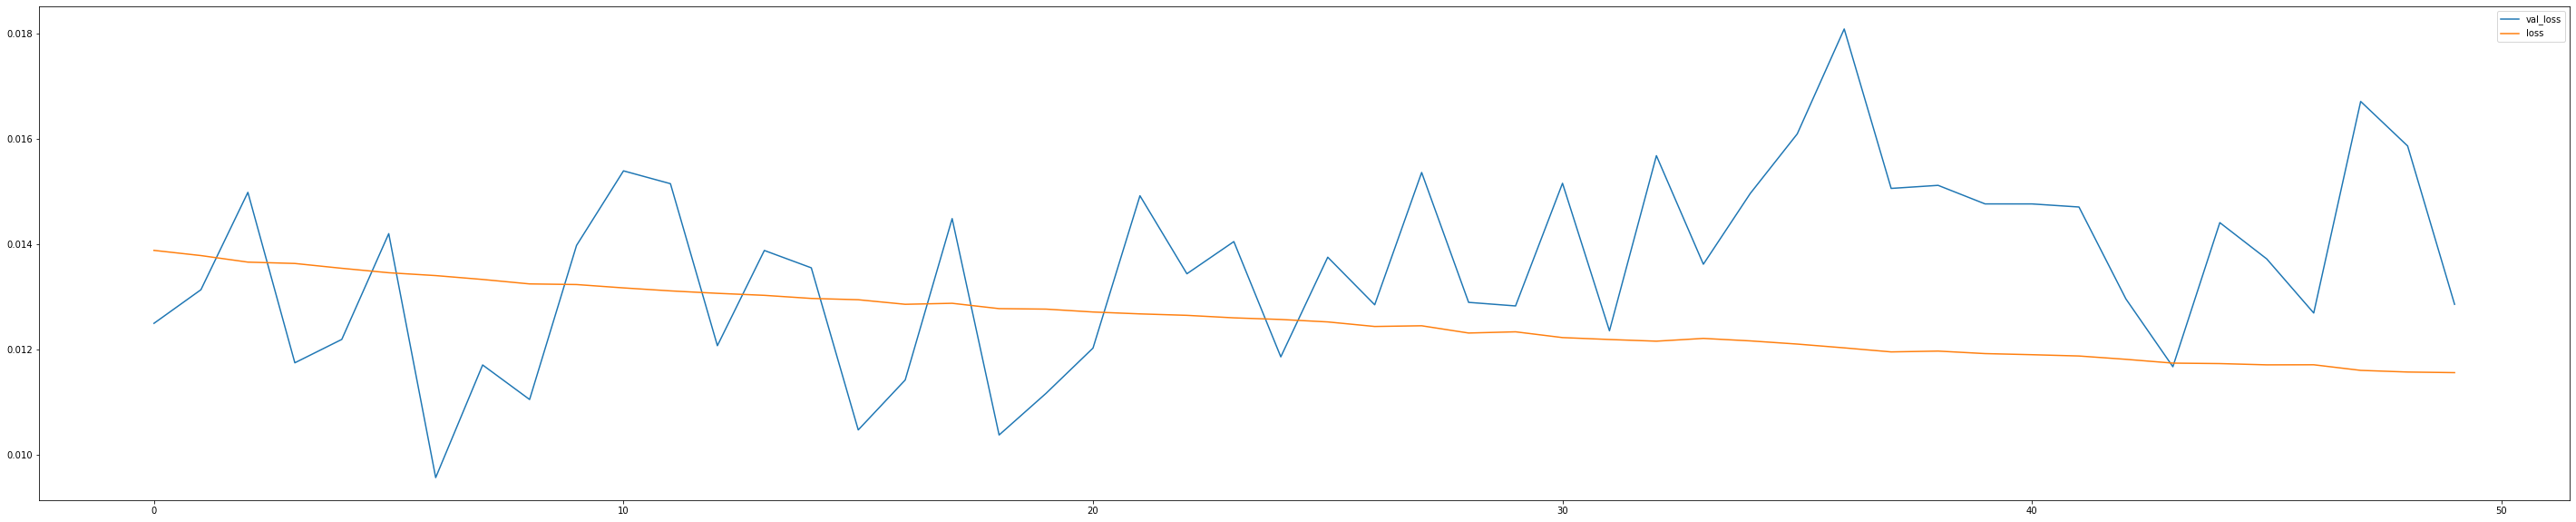

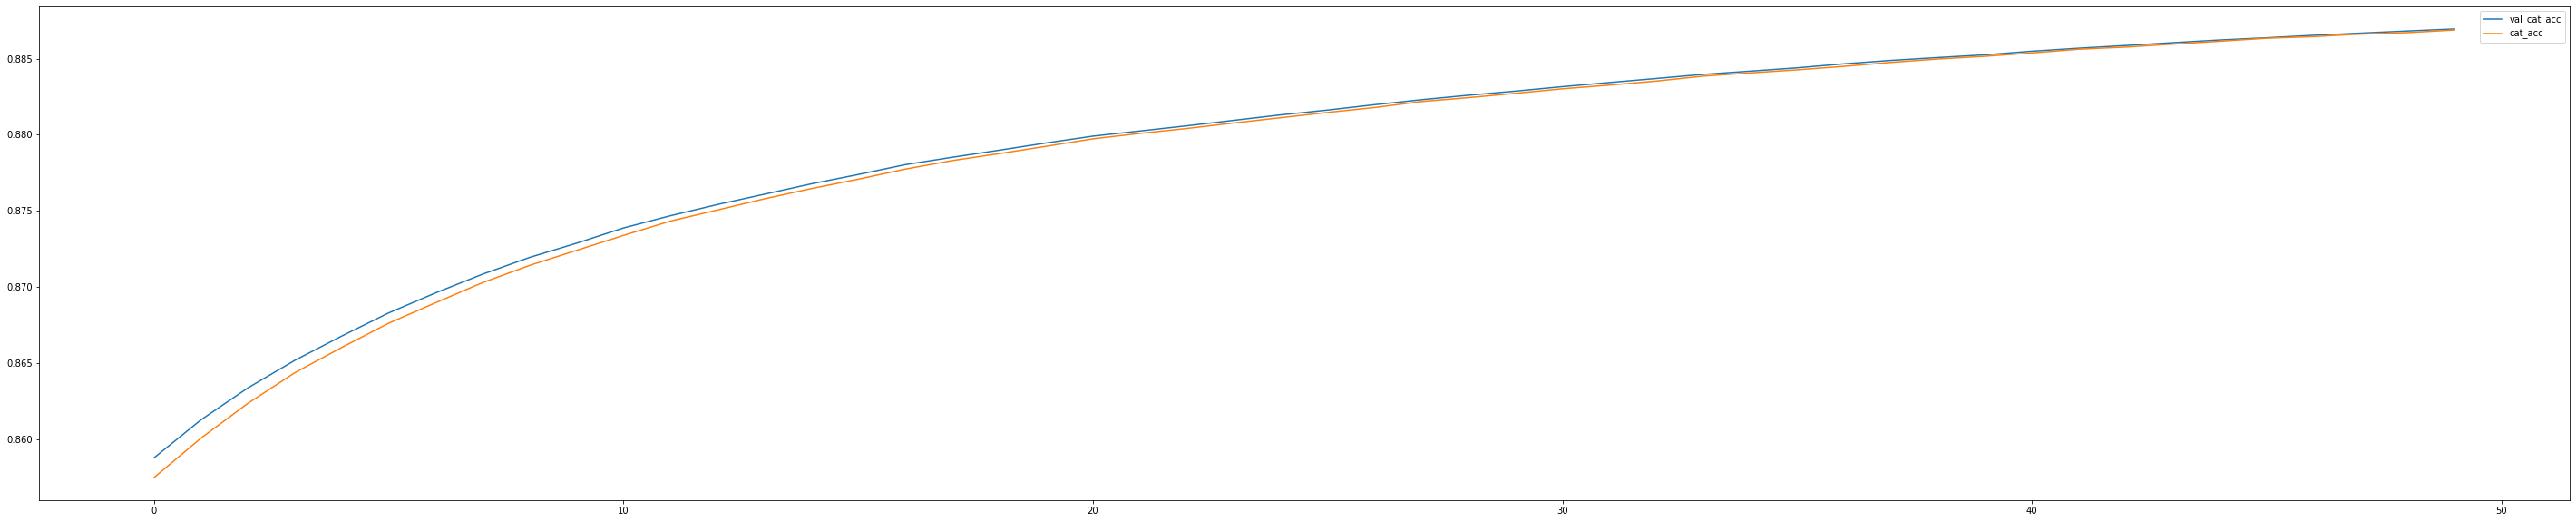

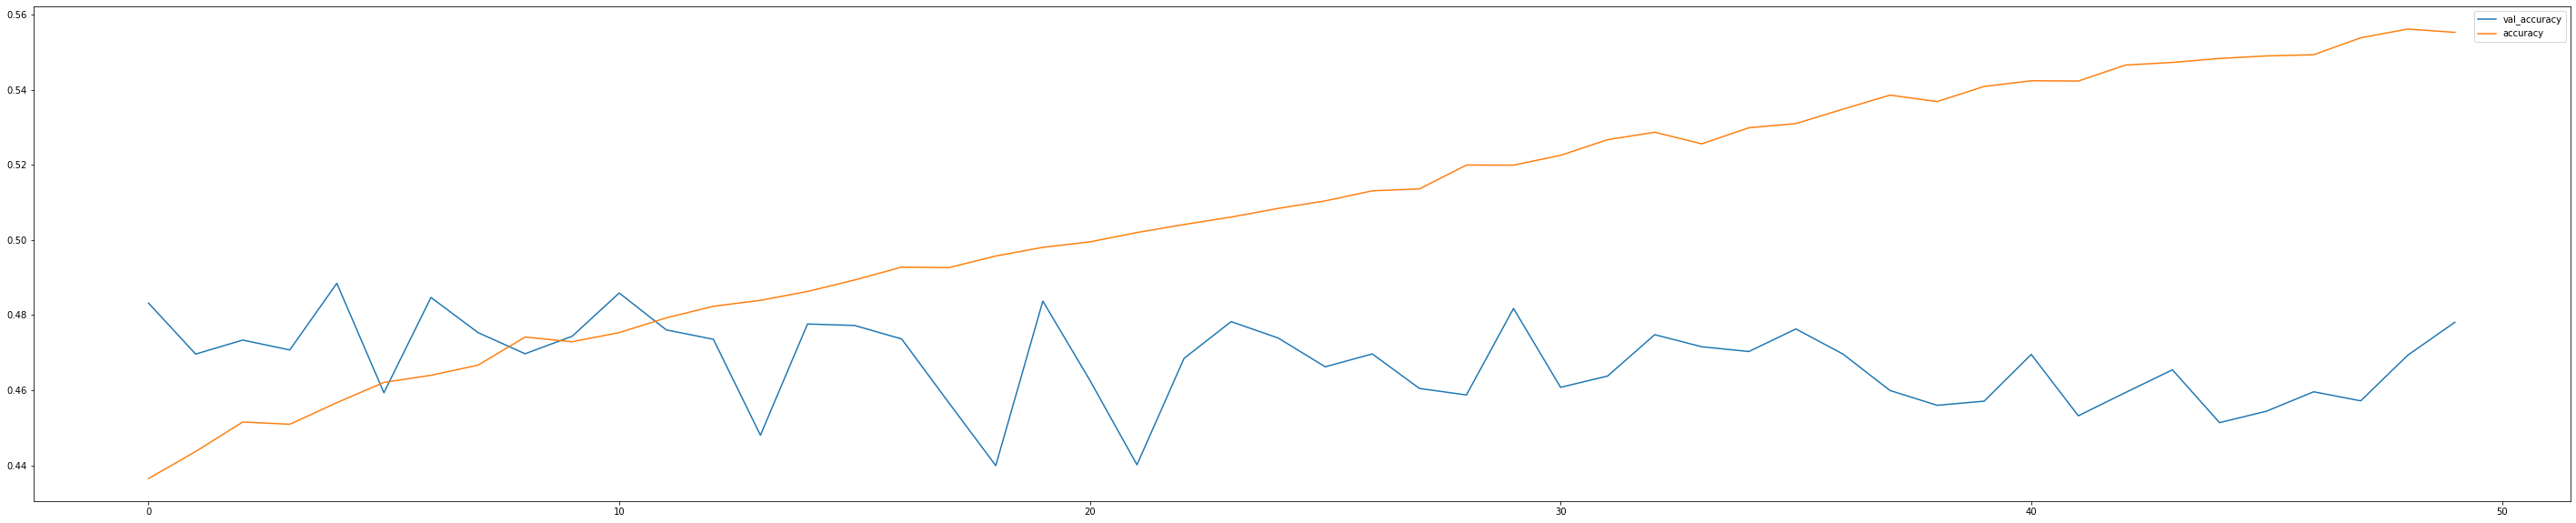

In [237]:
plt.plot(history.history.get('val_loss'),label='val_loss')
plt.plot(history.history.get('loss'),label='loss')
plt.legend()
plt.show()

plt.plot(history.history.get('val_top_k_categorical_accuracy'),label='val_cat_acc')
plt.plot(history.history.get('top_k_categorical_accuracy'),label='cat_acc')
plt.legend()
plt.show()

plt.plot(history.history.get('val_accuracy'),label='val_accuracy')
plt.plot(history.history.get('accuracy'),label='accuracy')
plt.legend()
plt.show()


In [277]:
model.load_weights('best_model_firstTrain.hdf5')

[0.00014544444, 0.00014792307, 0.00018949479, 0.0017953956, 0.0001709163, 0.00052613585, 0.0003688076, 0.00039257272, 0.00023909449, 0.00010644313, 0.00036329622, 0.0001229037, 0.000688532, 0.00042500577, 0.000574265, 0.00027405444, 0.00025361654, 0.0020485288, 0.0005252783, 0.0011839322, 0.00090035005, 0.0035609927, 0.0048467456, 0.0755248, 0.5227908, 0.13820902, 0.12800892, 0.027681692, 0.017069144, 0.03395666, 0.010452669, 0.0039867098, 0.0061794557, 0.0021251251, 0.0031479688, 0.0023788416, 0.0023075948, 0.0028767108, 0.0007481457, 0.00022704987, 0.00053582597, 0.00065890304, 0.00028899248, 0.00015146102, 0.0001378604, 0.00013441256, 0.0001208141, 0.00013494598, 0.00013896088, 0.00017678799]


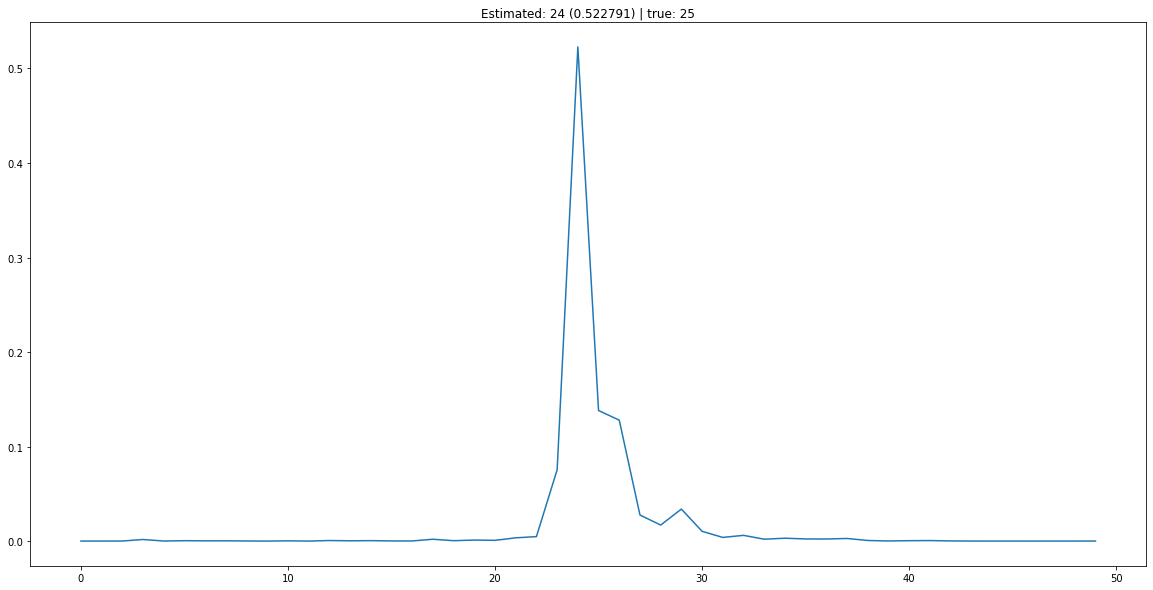

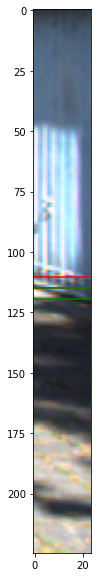

In [22]:
plt.rcParams['figure.figsize'] = [20, 10]

for t in test_generator:
    preds = model.predict(t[0])
    print(list(preds[0]))
    plt.plot(preds[0])
    plt.title('Estimated: %d (%f) | true: %d'%(np.argmax(preds[0]), max(preds[0]),np.argmax(t[1][0])))
    plt.show()
    plt.imshow(t[0][0])
    true = np.argmax(t[1][0])
    pred = np.argmax(preds[0])
    plt.axhline(y=bins[pred],color='red')
    plt.axhline(y=bins[pred+1],color='red')
    plt.axhline(y=bins[true],color='green')
    plt.axhline(y=bins[true+1],color='green')
    plt.show()
    break

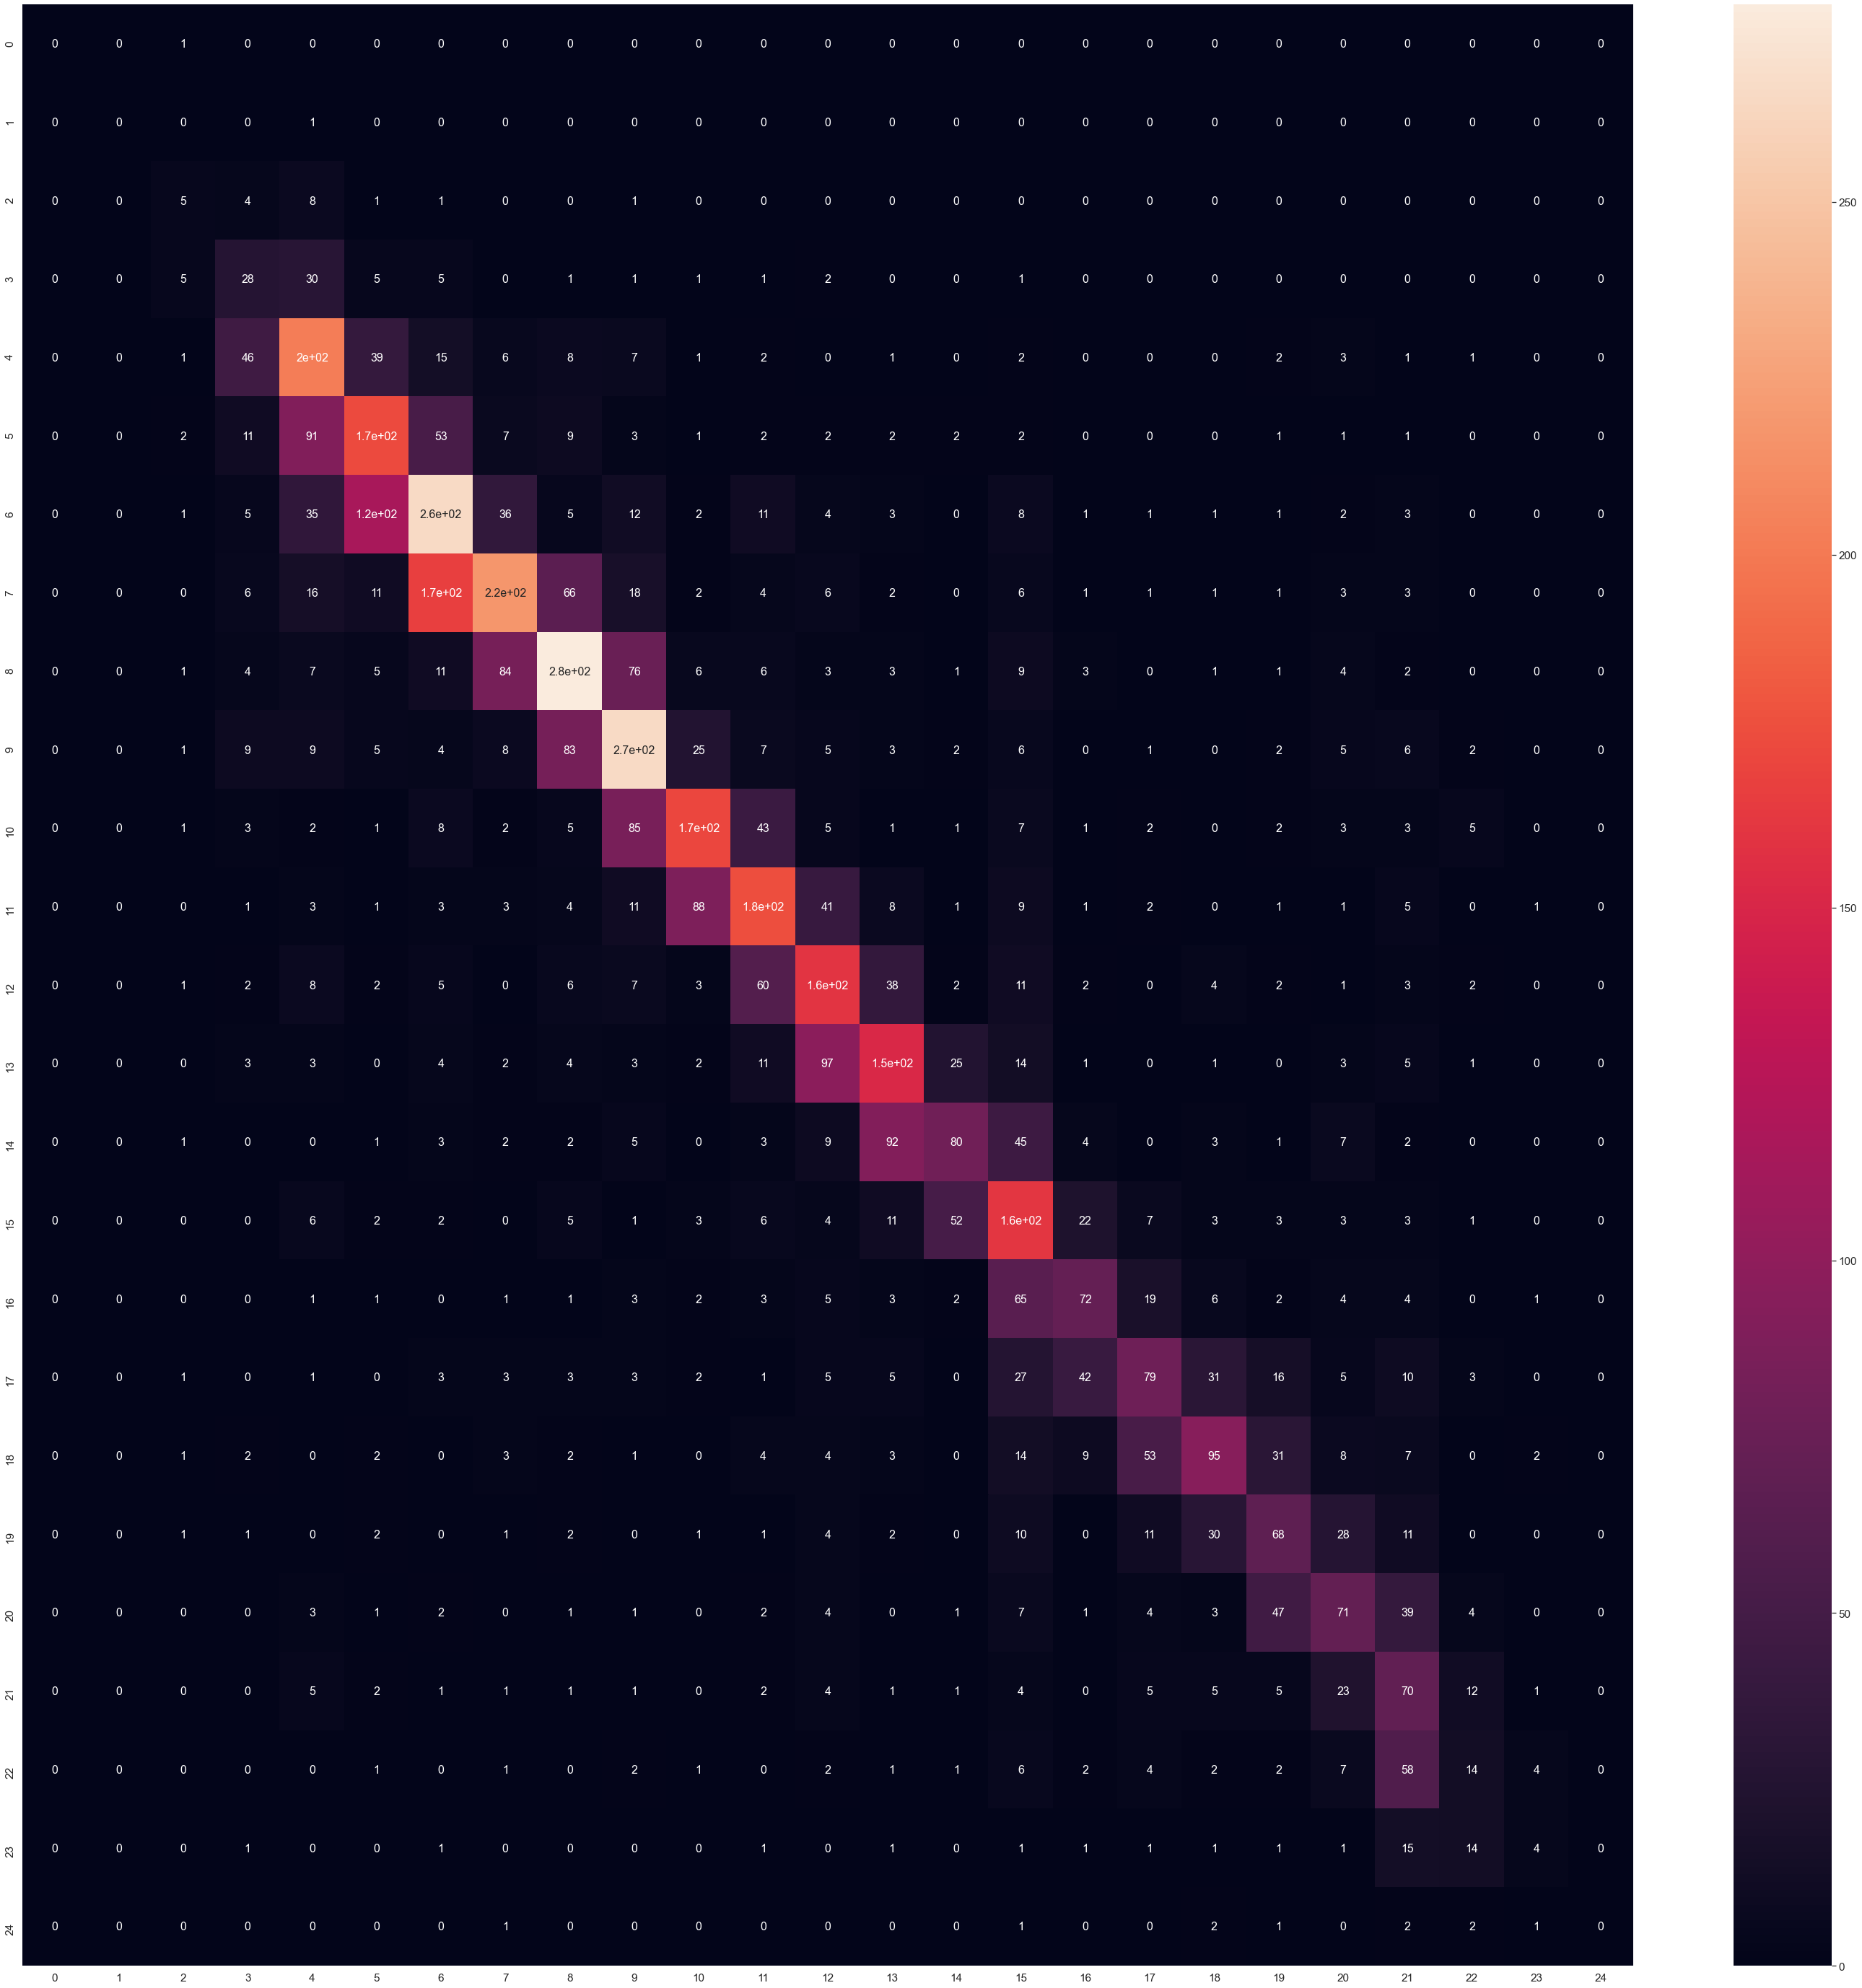

In [252]:
def preds_to_class_pred(preds):
    preds_class = []
    for i in range(len(preds)):
        preds_class.append(np.argmax(preds[i]))
    return preds_class

i = 0
y_pred = []
y_true = []
for t in test_generator:
    y_pred+=preds_to_class_pred(model.predict(t[0]))
    y_true+=preds_to_class_pred(t[1])
    if i>200:
        break
    i+=1

conf_matrix = confusion_matrix(y_true,y_pred)
df_cm = pd.DataFrame(confusion_matrix(y_true,y_pred), range(len(conf_matrix[0])), range(len(conf_matrix)))
plt.figure(figsize=(50,50))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from PIL import ImageOps

class ImgFrame:
    
    def __init__(self,imagePath):
        self.imagePath = imagePath
        self.image = Image.open(self.imagePath)
        self.image = self.image.resize((self.image.size[0],370))
        
    def getImage(self):
        return np.array(Image.open(self.imagePath))

    def getImageStixel(self,offset,stixelWidth):
        width = self.image.size[0]
        cropFromLeft = offset*stixelWidth 
        cropFromRight = width-(offset*stixelWidth)-stixelWidth
        if cropFromRight < 0:
            print('Offset too big for image.')
            return (None,-1)
        # left, up, right, bottom
        border = (cropFromLeft,0,cropFromRight, 0)
        return ImageOps.crop(self.image, border)
    
    def getImageStixels(self,stixelWidth):
        stixels = []
        for i in range(27):
            stixels.append(np.array(self.getImageStixel(i,stixelWidth)) / 255.)
        return np.array(stixels)

In [280]:
model.load_weights('training_wo_flips/best_model.hdf5')

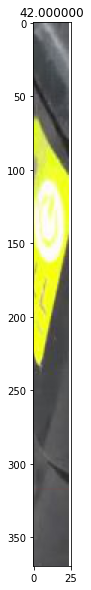

In [281]:
img = ImgFrame('trash_bins/ezgif-frame-055.jpg')
img.getImageStixels(24)[0]

preds = model.predict(img.getImageStixels(24))
stixels = img.getImageStixels(24)

for i in range(len(stixels)):
    plt.imshow(stixels[i])
    plt.title('%f'%np.argmax(preds[i]))
    plt.hlines(bins[np.argmax(preds[i])],0,24,alpha=max(preds[i]),color='red')
    plt.show()
    clear_output(wait=True)


In [274]:
import glob
imgs = glob.glob("trash_bins/*.jpg")
img = ImgFrame(imgs[0])

In [89]:
model.load_weights('best_model.hdf5')

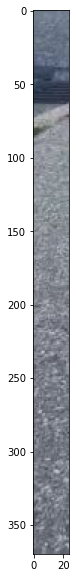

4.591836734693878
38 0.99995184


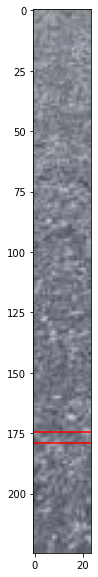

38 1.0


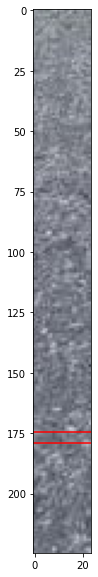

38 1.0


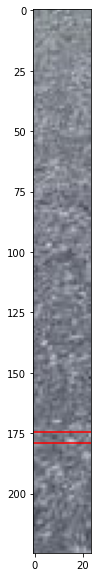

36 0.93948364


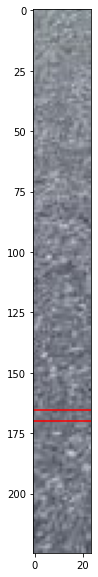

36 0.99974555


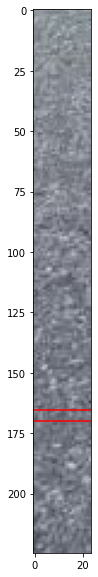

36 0.99972576


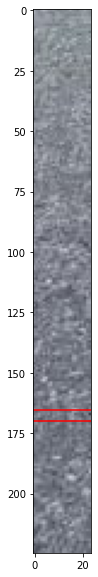

36 0.9999974


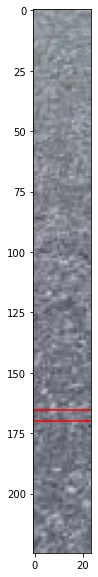

38 0.9999746


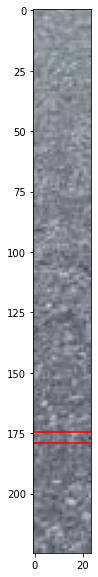

38 1.0


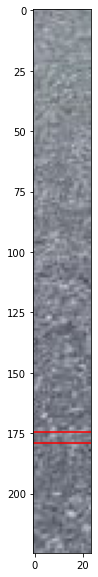

38 1.0


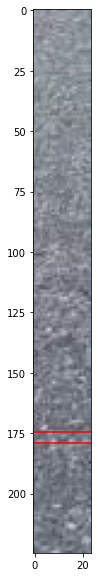

38 1.0


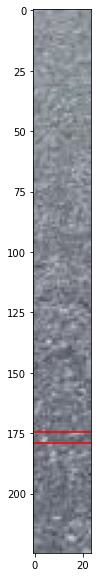

38 1.0


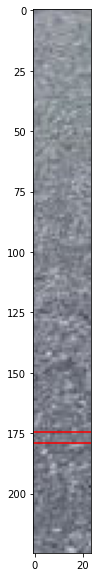

38 1.0


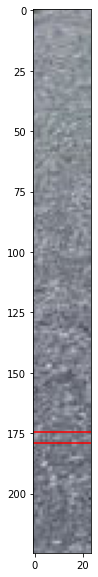

38 0.9982827


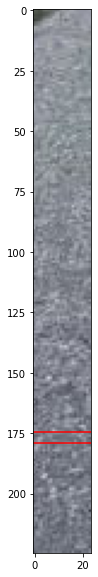

36 0.9986846


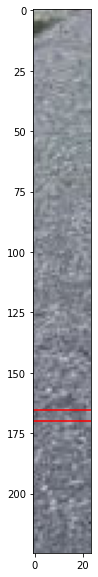

38 1.0


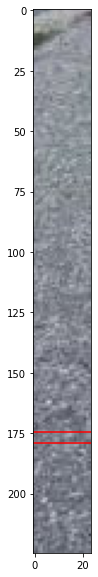

38 1.0


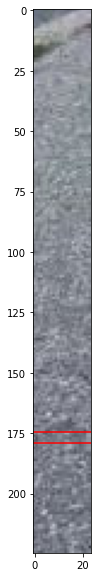

36 0.9997458


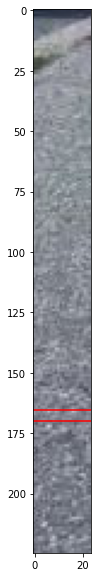

15 1.0


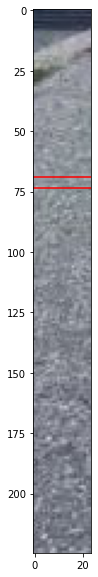

36 0.9985689


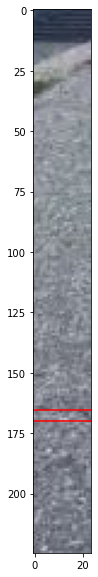

36 0.9981797


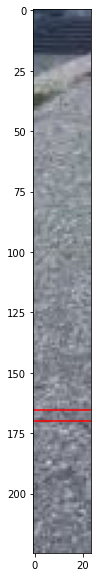

38 1.0


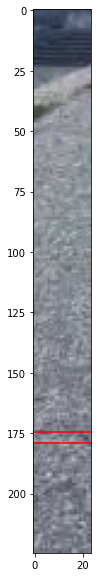

36 1.0


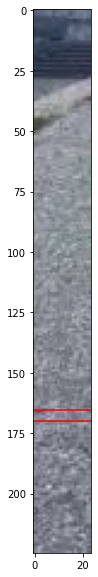

13 1.0


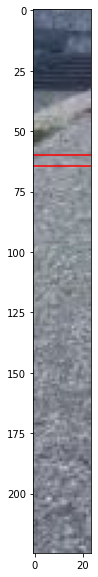

15 1.0


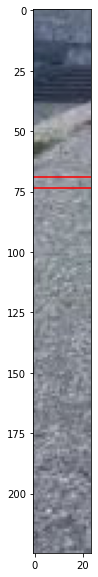

15 1.0


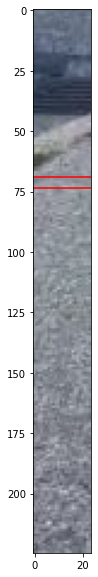

15 0.9999993


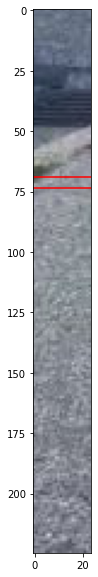

36 0.98617107


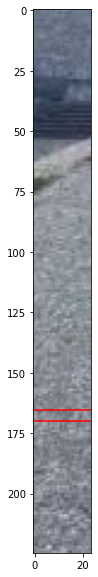

38 1.0


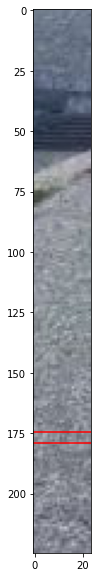

In [102]:
img = ImgFrame(imgs[80])


stixel = img.getImageStixel(3,24)


plt.imshow(stixel)
plt.show()

#plt.imshow(stixel)
#plt.show()


print(bins[1]-bins[0])

for inp in range(0,145,int(round(bins[1]-bins[0]))):
    offset = 145-inp
    #print(offset)
    cropped = ImageOps.crop(stixel, (0,145-inp,0,inp))
    cropped = np.array(cropped).reshape(1,225,24,3)
    preds = model.predict(cropped)
    pred = np.argmax(preds[0])
    print(pred,preds[0][pred])
    plt.imshow(cropped[0])
    plt.axhline(y=bins[pred],color='red')
    plt.axhline(y=bins[pred+1],color='red')
    plt.show()


if False:
    preds = model.predict(cropped)
    print(list(preds[0]))
    plt.plot(preds[0])
    plt.show()
    plt.imshow(stixel.crop(cr1))
    pred = np.argmax(preds[0])
    plt.axhline(y=bins[pred],color='red')
    plt.axhline(y=bins[pred+1],color='red')
    plt.show()



In [39]:
for i in img.getImageStixels(24):
    plt.hlines(bins[np.argmax(preds[6])],(6)*24,(6+1)*24,color='red',alpha=max(preds[6]))
    plt.imshow(i)
    plt.show()
    break

NameError: name 'img' is not defined

In [26]:
import glob
imgs = glob.glob("trash_bag/*.jpg")

threshold = 0.6
out_dir = 'trash_bins_out/'

counter = 0
for img_path in imgs:
    img = ImgFrame(img_path)
    plt.rcParams['figure.figsize'] = [50, 10]
    preds = model.predict(img.getImageStixels(24))
    global_max = 0
    for i in range(27):
        if global_max < max(preds[i]):
            global_max = max(preds[i])
        if global_max > threshold:
            plt.hlines(bins[np.argmax(preds[i])],(i)*24,(i+1)*24,color='red',alpha=max(preds[i]))
    plt.title('Confidence for obstacle: %.2f%%'%global_max)
    plt.imshow(img.getImage())
    plt.savefig(out_dir + '%d.png'%counter,bbox_inches='tight', pad_inches=0)
    counter+=1
    plt.show()
    clear_output(wait=True)

ValueError: Error when checking input: expected input_1 to have shape (225, 24, 3) but got array with shape (370, 24, 3)

In [ ]:
def splitImageStixel(stixel,split_height):
    splits = []
    stixel_height = stixel.size[1]
    for i in range(0,stixel_height-split_height+1):
        cropped = ImageOps.crop(stixel, border)
        splits.append(cropped)
    return splits


len(splitImageStixel(Image.open('data_train/stixels/270.png'),138))